In [1]:
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
connector=pd.read_csv('../connector/connector.csv')
clinical = connector.drop(columns=['date','lesion_clinical','lesion_rtstruct','lesion_clean','file_name'])
conincal = clinical.rename(columns={'sid':'pid', 'mri_type': 'label'})
columns = [col for col in clinical.columns]
clinical = clinical[['sid', 'course', 'lesion', 'Diagnosis (Only want Mets)', 'Primary Diagnosis', 'Age at Diagnosis', 'Gender', 'Lesion #', 'mri_type', 'duration_tx_to_imag (months)', 'Fractions']]
clinical.head(1)


,sid,course,lesion,Diagnosis (Only want Mets),Primary Diagnosis,Age at Diagnosis,Gender,Lesion #,mri_type,duration_tx_to_imag (months),Fractions
0,103,1,Left Temporal,Mets Ovary,Serous carcinoma,75,Female,2,stable,13.572133,1


In [3]:
folder = 'pickle'

In [4]:
features = pd.DataFrame()
for file in os.listdir(folder):
    with open(os.path.join(folder,file), 'rb') as file:
        data = pickle.load(file)
        features = pd.concat([features,data])
features.reset_index(drop=1,inplace=True)
features.drop(['iterations','iteration','n_splits','num_epochs'],axis=1,inplace=True)

In [5]:
features.head(1)

,fold,train_losses,val_losses,best_y_true,best_y_pred,best_f1,train_f1,val_f1,train_features,val_features,test_features,best_epoch,model_name,loss,batch_size,learning_rate
0,0,"[0.3714209641603863, 4.325151035233455, 3.7311...","[0.16726146024816177, 1.876867520458558, 0.348...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",0.4,0.352941,0.166667,"([[35.934723, 0.0, 12.64718, 0.0, 0.0, 0.0, 0....","([[33.993042, 0.0, 8.250039, 0.0, 0.0, 0.0, 0....","([[31.262487, 0.0, 5.377471, 0.0, 0.0, 0.0, 0....",1,MidFusion3DCNN,CrossEntropy,4,0.01


In [6]:
df_features = pd.DataFrame()
for index, row in features.iterrows():
    data=row[['model_name','loss','batch_size','learning_rate','fold','train_features','val_features','test_features']]
    for source in [('train','train_features'),('val','val_features'),('test','test_features')]:
        features_,labels,lesions_=data[source[1]]
        df=pd.DataFrame()
        pid = []
        course = []
        lesions = []
        for item in lesions_:
            parts = item.split('_')
            pid.append(parts[0])        # First part
            course.append(parts[1])     # Second part
            lesions.append(parts[2])    # Third part
        df['pid'] = pid
        df['course'] = course
        df['lesion'] = lesions
        df['split']=[source[0]]*len(labels)
        df['model_name']=data['model_name']
        df['loss']=data['loss']
        df['batch_size']=data['batch_size']
        df['learning_rate']=data['learning_rate']
        df['fold']=data['fold']
        df['labels']=labels
        df['features']=features_.tolist()
        df_features=pd.concat([df_features,df])
df_features.reset_index(drop=True,inplace=True)
df_features.pid=df_features.pid.astype(int)
df_features.course=df_features.course.astype(int)
df_features.labels=df_features.labels.astype(int)


In [7]:
df_features.head(1)

,pid,course,lesion,split,model_name,loss,batch_size,learning_rate,fold,labels,features
0,151,1,7 Left Medial Parietal 1,train,MidFusion3DCNN,CrossEntropy,4,0.01,0,0,"[35.934722900390625, 0.0, 12.64717960357666, 0..."


In [8]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier

def fine_best_model(X_train, y_train):

    model = XGBClassifier(tree_method="hist", enable_categorical=True)
    weights = range(50, 200, 10)
    param_grid = dict(scale_pos_weight=weights)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
    grid_result = grid.fit(X_train, y_train)

    best_model = grid_result.best_estimator_

    return best_model

In [9]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier
import numpy as np

def fine_best_model(X_train, y_train):
    # Initial model setup
    model = XGBClassifier(tree_method="hist", enable_categorical=True)

    # Calculate scale_pos_weight for imbalanced dataset
    # Example: Negative class is the majority class
    weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    # Parameter grid for grid search
    param_grid = {
        'scale_pos_weight': [weight * 0.5, weight, weight * 1.5],  # Example adjustment around calculated weight
        'max_depth': [6, 10, 15], 
        'min_child_weight': [1, 5, 10] 
    }
    
    # Setup for cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)  # Adjusted for computational efficiency
    
    # Grid search setup
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
    
    # Fitting the model
    grid_result = grid.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_result.best_estimator_

    # Optionally, print out the results
    # print("Best F1 Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # for params, mean_score, std_score in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']):
    #     print("%f (%f) with: %r" % (mean_score, std_score, params))

    return best_model


In [10]:
from numpy import mean
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve, confusion_matrix, accuracy_score

def get_scores(model, X_val, y_val, reference='f1'):
    y_prob = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0, 1, 101)

    if reference == 'f1':
        f1_scores = [f1_score(y_val, [1 if prob >= threshold else 0 for prob in y_prob]) for threshold in thresholds]
        best_threshold = thresholds[np.argmax(f1_scores)]
    elif reference == 'accuracy':
        accuracy_scores = [accuracy_score(y_val, [1 if prob >= threshold else 0 for prob in y_prob]) for threshold in thresholds]
        best_threshold = thresholds[np.argmax(accuracy_scores)]
    elif reference == None:
        best_threshold  = 0.5
        y_pred = [1 if prob >= 0.5 else 0 for prob in y_prob]
    
    y_pred = [1 if prob >= best_threshold else 0 for prob in y_prob]

    # Calculate metrics
    precision = precision_score(y_val, y_pred,zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    accuracy = accuracy_score(y_val, y_pred)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_val, y_prob)  # For binary classification
    
    # Calculate AUC-PR
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_prob)
    auc_pr = auc(recall_curve, precision_curve)   

    return {'threshold': best_threshold, 'reference': reference, 'y_prob':y_prob, 'y_pred':y_pred, 'precision': precision,'recall': recall, 'f1': f1, 'roc_auc': roc_auc, 'auc_pr': auc_pr, 'accuracy': accuracy,'snity': sensitivity,'specificity': specificity, 'confusion_matrix': cm}    

In [11]:
# Updated placeholders for models and their evaluation scores
models = {}
eval_metrics = {}

# Iterate through each unique combination
for _, group_data in df_features.groupby(['model_name', 'loss', 'batch_size', 'learning_rate', 'fold']):
    # Split the grouped data into train and validation sets
    train_data = group_data[group_data['split'] == 'train']
    val_data = group_data[group_data['split'] == 'val']
    
    # Extract features and labels
    X_train = np.array(train_data['features'].tolist())
    y_train = train_data['labels'].values
    
    X_val = np.array(val_data['features'].tolist())
    y_val = val_data['labels'].values
    
    model = fine_best_model(X_train, y_train)

    scores = get_scores(model, X_val, y_val, 'accuracy')


    # Save metrics
    model_identifier = (group_data['model_name'].iloc[0], group_data['loss'].iloc[0], group_data['batch_size'].iloc[0], group_data['learning_rate'].iloc[0], group_data['fold'].iloc[0])
    eval_metrics[model_identifier] = scores
    models[model_identifier] = model


In [14]:
thresh=np.argmax([f1_score((np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>x).astype(int),y_val) for x in range(len(eval_metrics))])
ens_y_pred = (np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>thresh).astype(int)
print(f"f1: {np.round(f1_score(ens_y_pred,y_val),2)}, \naccuracy: {np.round(accuracy_score(ens_y_pred,y_val),2)},\nrecall: {recall_score(ens_y_pred,y_val)},\nprecision: {precision_score(ens_y_pred,y_val)},\nconfusion matrix: \n{confusion_matrix(ens_y_pred,y_val)},\nthreshold: {thresh}")

f1: 0.75, 
accuracy: 0.95,
recall: 0.75,
precision: 0.75,
confusion matrix: 
[[32  1]
 [ 1  3]],
threshold: 13


In [ ]:
pd.read_pickle('eval_metrics_f1.pkl').accuracy.max()

In [16]:
pickle.dump(models, open('models_accuracy.pkl', 'wb'))

In [15]:
pickle.dump(pd.DataFrame(eval_metrics).T, open('eval_metrics_accuracy.pkl', 'wb'))

In [ ]:
pd.DataFrame(eval_metrics).T.to_pickle("eval_metrics_f1.pkl")

Add Some Additional Clinical Data

In [17]:
extended_clinical = pd.read_csv('clinical_clean_met_1_with_height.csv')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Assuming 'mri_type' is the column you want to encode
label_mapping = {'stable': 0, 'recurrence': 1}
extended_clinical['label'] = extended_clinical['label'].map(label_mapping)
extended_clinical.rename(columns={'label': 'labels'}, inplace=True)
extended_clinical.pid = extended_clinical.pid.astype(int)
extended_clinical.course = extended_clinical.course.astype(int)
extended_clinical.labels = extended_clinical.labels.astype(int)
extended_clinical.lesion = extended_clinical.lesion.str.strip()

extended_clinical.head(1)

,pid,course,lesion_clinical,lesion_rtstruct,lesion,metastasis,primary diagnosis,age at diagnosis,gender,lesion #,labels,duration_tx_to_imag (months),fractions,sex,height,weight,age
0,151,1,1 Lt Inf Cerebellar1,1 Lt Inf Cerebellar 1,1 Left Inferior Cerebellar 1,Lung,Adenocarcinoma of the lung,77,Female,1,0,42.458101,1,F,1.69,70,78


In [18]:
extended_clinical.shape

(244, 17)

In [19]:
df_features.head(1)

,pid,course,lesion,split,model_name,loss,batch_size,learning_rate,fold,labels,features
0,151,1,7 Left Medial Parietal 1,train,MidFusion3DCNN,CrossEntropy,4,0.01,0,0,"[35.934722900390625, 0.0, 12.64717960357666, 0..."


In [20]:
for _, group_data in df_features.groupby(['model_name', 'loss', 'batch_size', 'learning_rate', 'fold']):
    # Split the grouped data into train and validation sets
    train_data = group_data[group_data['split'] == 'train']
    val_data = group_data[group_data['split'] == 'val']
    break

splits=group_data[['pid','course','lesion','split']].reset_index(drop=True)
train_split = splits[splits.split=='train']
val_split = splits[splits.split=='val']
test_split = splits[splits.split=='test']
splits.shape,train_split.shape,val_split.shape,test_split.shape

((244, 4), (170, 4), (37, 4), (37, 4))

In [21]:
train_split.head(1)

,pid,course,lesion,split
0,151,1,7 Left Medial Parietal 1,train


In [22]:
extended_clinical=extended_clinical.merge(splits,on=['pid','course','lesion'],how='inner')
extended_clinical.shape


(244, 18)

In [23]:
extended_clinical.head(1)

,pid,course,lesion_clinical,lesion_rtstruct,lesion,metastasis,primary diagnosis,age at diagnosis,gender,lesion #,labels,duration_tx_to_imag (months),fractions,sex,height,weight,age,split
0,151,1,1 Lt Inf Cerebellar1,1 Lt Inf Cerebellar 1,1 Left Inferior Cerebellar 1,Lung,Adenocarcinoma of the lung,77,Female,1,0,42.458101,1,F,1.69,70,78,train


In [24]:
extended_clinical.columns

Index(['pid', 'course', 'lesion_clinical', 'lesion_rtstruct', 'lesion',
       'metastasis', 'primary diagnosis', 'age at diagnosis', 'gender',
       'lesion #', 'labels', 'duration_tx_to_imag (months)', 'fractions',
       'sex', 'height', 'weight', 'age', 'split'],
      dtype='object')

In [25]:
df_features.columns

Index(['pid', 'course', 'lesion', 'split', 'model_name', 'loss', 'batch_size',
       'learning_rate', 'fold', 'labels', 'features'],
      dtype='object')

In [26]:
df_features.shape,extended_clinical.shape

((87840, 11), (244, 18))

In [81]:
df_features.lesion = df_features.lesion.str.strip()
df_features_clinical = df_features.merge(extended_clinical,on=['pid','course','lesion','labels','split'],how='inner') 

df_features_clinical.shape

(87840, 24)

In [82]:
df_features_clinical.head(1)

,pid,course,lesion,split,model_name,loss,batch_size,learning_rate,fold,labels,...,primary diagnosis,age at diagnosis,gender,lesion #,duration_tx_to_imag (months),fractions,sex,height,weight,age
0,151,1,7 Left Medial Parietal 1,train,MidFusion3DCNN,CrossEntropy,4,0.01,0,0,...,Adenocarcinoma of the lung,77,Female,7,42.458101,1,F,1.69,70,78


In [83]:
df_features_clinical=df_features_clinical.drop(['lesion_clinical','lesion_rtstruct'],axis=1)
df_features_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pid                           87840 non-null  int64  
 1   course                        87840 non-null  int64  
 2   lesion                        87840 non-null  object 
 3   split                         87840 non-null  object 
 4   model_name                    87840 non-null  object 
 5   loss                          87840 non-null  object 
 6   batch_size                    87840 non-null  int64  
 7   learning_rate                 87840 non-null  float64
 8   fold                          87840 non-null  int64  
 9   labels                        87840 non-null  int64  
 10  features                      87840 non-null  object 
 11  metastasis                    87840 non-null  object 
 12  primary diagnosis             87840 non-null  object 
 13  a

In [85]:
object_columns = df_features_clinical.select_dtypes(include='object').columns
object_columns=object_columns.drop(['features','model_name', 'loss'])
df_features_clinical[object_columns] = df_features_clinical[object_columns].astype('category')

In [86]:
df_features_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   pid                           87840 non-null  int64   
 1   course                        87840 non-null  int64   
 2   lesion                        87840 non-null  category
 3   split                         87840 non-null  category
 4   model_name                    87840 non-null  object  
 5   loss                          87840 non-null  object  
 6   batch_size                    87840 non-null  int64   
 7   learning_rate                 87840 non-null  float64 
 8   fold                          87840 non-null  int64   
 9   labels                        87840 non-null  int64   
 10  features                      87840 non-null  object  
 11  metastasis                    87840 non-null  category
 12  primary diagnosis             87840 non-null  

In [113]:
# Updated placeholders for models and their evaluation scores
models = {}
eval_metrics = {}

# Iterate through each unique combination
for _, group_data in df_features_clinical.groupby(['model_name', 'loss', 'batch_size', 'learning_rate', 'fold']):
    # Split the grouped data into train and validation sets
    learn = ['course', 'lesion', 'metastasis','primary diagnosis', 'age at diagnosis', 'gender', 'lesion #','duration_tx_to_imag (months)', 'fractions', 'sex', 'height', 'weight','age']
    train_data = group_data[group_data['split'] == 'train']
    val_data = group_data[group_data['split'] == 'val']
    train_features = np.array(train_data['features'].tolist())
    val_features = np.array(val_data['features'].tolist())

    y_train = np.array(train_data['labels'].tolist())
    y_val = np.array(val_data['labels'].tolist())

    train_data=train_data[learn]
    val_data=val_data[learn]

    # Extract features and labels
    a=pd.DataFrame(train_features).reset_index(drop=True)
    b=train_data.reset_index(drop=True)
    X_train = pd.concat([a,b],axis=1,ignore_index=True)

    a=pd.DataFrame(val_features).reset_index(drop=True)
    b=val_data.reset_index(drop=True)
    X_val = pd.concat([a,b],axis=1,ignore_index=True)
    
    model = fine_best_model(X_train, y_train)

    scores = get_scores(model, X_val, y_val, 'accuracy')


    # Save metrics
    model_identifier = (group_data['model_name'].iloc[0], group_data['loss'].iloc[0], group_data['batch_size'].iloc[0], group_data['learning_rate'].iloc[0], group_data['fold'].iloc[0])
    eval_metrics[model_identifier] = scores
    models[model_identifier] = model


In [139]:
predictions = []
performance_scores = []
for k,v in eval_metrics.items():
    predictions.append(v['y_pred'])
    performance_scores.append(v['accuracy'])


In [140]:
N = 10  # Choose how many top models you want to include in the ensemble
top_models_indices = np.argsort(performance_scores)[-N:]

# Average predictions of the top N models for each sample
top_model_predictions = np.array([predictions[i] for i in top_models_indices])
final_predictions = top_model_predictions.mean(axis=0)

In [159]:
np.vstack(best)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

In [193]:
results={'pr_auc':[],'accuracy':[],'recall':[],'precision':[],'f1':[],'roc_auc':[]}
threshs = 100
for i in range(1,len(eval_metrics)+1):
    
    #f1
    best_pred=np.mean(np.vstack(pd.DataFrame(eval_metrics).T.sort_values(by='f1', ascending=False).head(i).y_pred.values),axis=0)
    thresh=np.argmax([f1_score((best_pred>x).astype(int),y_val,zero_division=0) for x in np.linspace(0.01,1,threshs)])
    results['f1'].append(f1_score((best_pred>thresh).astype(int),y_val,zero_division=0))

    #accuracy
    best_pred=np.mean(np.vstack(pd.DataFrame(eval_metrics).T.sort_values(by='accuracy', ascending=False).head(i).y_pred.values),axis=0)
    thresh=np.argmax([accuracy_score((best_pred>x).astype(int),y_val) for x in np.linspace(0.01,1,threshs)])
    results['accuracy'].append(accuracy_score((best_pred>thresh).astype(int),y_val))

    #recall
    best_pred=np.mean(np.vstack(pd.DataFrame(eval_metrics).T.sort_values(by='recall', ascending=False).head(i).y_pred.values),axis=0)
    thresh=np.argmax([recall_score((best_pred>x).astype(int),y_val,zero_division=0) for x in np.linspace(0.01,1,threshs)])
    results['recall'].append(recall_score((best_pred>thresh).astype(int),y_val,zero_division=0))

    #precision
    best_pred=np.mean(np.vstack(pd.DataFrame(eval_metrics).T.sort_values(by='precision', ascending=False).head(i).y_pred.values),axis=0)
    thresh=np.argmax([precision_score((best_pred>x).astype(int),y_val,zero_division=0) for x in np.linspace(0.01,1,threshs)])
    results['precision'].append(precision_score((best_pred>thresh).astype(int),y_val,zero_division=0))

    #pr_auc
    best_pred=np.mean(np.vstack(pd.DataFrame(eval_metrics).T.sort_values(by='f1', ascending=False).head(i).y_pred.values),axis=0)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, best_pred)
    results['pr_auc'].append(auc(recall_curve, precision_curve))

    #roc_auc
    results['roc_auc'].append(roc_auc_score(y_val, best_pred))


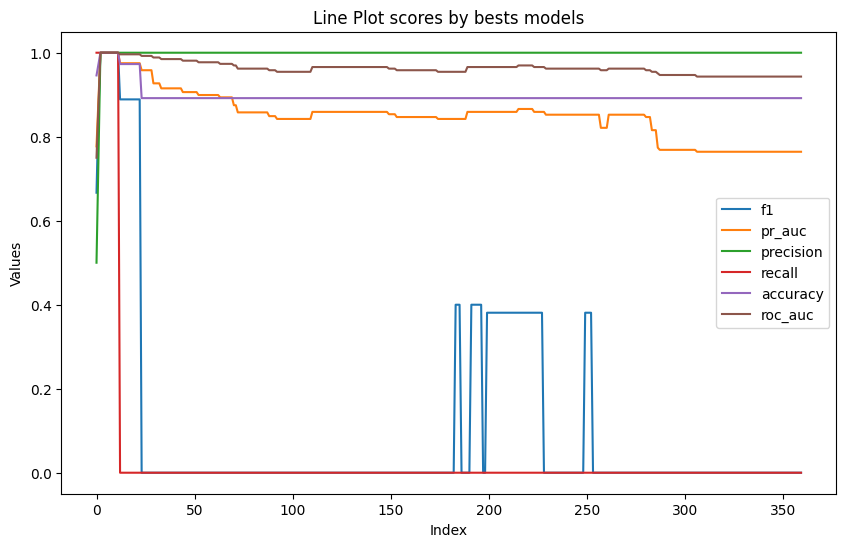

In [194]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(df['f1'], label='f1')
plt.plot(df['pr_auc'], label='pr_auc')
plt.plot(df['precision'], label='precision') 
plt.plot(df['recall'], label='recall') 
plt.plot(df['accuracy'], label='accuracy') 
plt.plot(df['roc_auc'], label='roc_auc') 

# Adding title and labels
plt.title('Line Plot scores by bests models')
plt.xlabel('Index')
plt.ylabel('Values')

# Displaying the legend
plt.legend()

# Showing the plot
plt.show()


In [178]:
[f1_score((best_pred>x).astype(int),y_val) for x in range(0.01,1,0.01)]

TypeError: 'float' object cannot be interpreted as an integer

In [145]:
thresh=np.argmax([f1_score((np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>x).astype(int),y_val) for x in range(len(eval_metrics))])


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [ ]:
ens_y_pred = (np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>thresh).astype(int)
f1_score(ens_y_pred,y_val),np.round(accuracy_score(ens_y_pred,y_val),2),recall_score(ens_y_pred,y_val),precision_score(ens_y_pred,y_val),confusion_matrix(ens_y_pred,y_val),thresh

In [ ]:
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_prob)
    auc_pr = auc(recall_curve, precision_curve)  

In [144]:
f1_score(final_predictions,y_val)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [137]:
eval_metrics

{('EarlyFusion3DCNN',
  'CrossEntropy',
  4,
  0.0001,
  0): {'threshold': 0.5700000000000001, 'reference': 'accuracy', 'y_prob': array([0.02064546, 0.32287645, 0.03617987, 0.02046044, 0.00161128,
         0.02748624, 0.0766041 , 0.00754537, 0.03736186, 0.00257047,
         0.01038377, 0.8198293 , 0.01479593, 0.10442398, 0.00934048,
         0.00911853, 0.03888392, 0.06548145, 0.00697873, 0.00468297,
         0.01296642, 0.00873878, 0.03227805, 0.01061549, 0.01117571,
         0.00474684, 0.03466207, 0.0276731 , 0.08119785, 0.4446495 ,
         0.00638752, 0.71122926, 0.5138354 , 0.04946912, 0.56309015,
         0.12483737, 0.10442398], dtype=float32), 'y_pred': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0], 'precision': 0.5, 'recall': 0.25, 'f1': 0.3333333333333333, 'roc_auc': 0.6174242424242424, 'auc_pr': 0.17139

In [115]:
thresh=np.argmax([f1_score((np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>x).astype(int),y_val) for x in range(len(eval_metrics))])
ens_y_pred = (np.sum(np.array([np.array(lst) for lst in np.array(pd.DataFrame(eval_metrics).T.y_pred.values)]),axis=0)>thresh).astype(int)
f1_score(ens_y_pred,y_val),np.round(accuracy_score(ens_y_pred,y_val),2),recall_score(ens_y_pred,y_val),precision_score(ens_y_pred,y_val),confusion_matrix(ens_y_pred,y_val),thresh

(0.75,
 0.95,
 0.75,
 0.75,
 array([[32,  1],
        [ 1,  3]]),
 18)

In [131]:
predictions = []
for k,v in eval_metrics.items():
    predictions.append(v['y_pred'])
X_meta = np.array(predictions).T
X_meta.shape

(37, 360)

In [133]:
y_meta = y_val

In [135]:
from xgboost import XGBClassifier  # or XGBRegressor for regression tasks

# Initialize the meta-model
meta_model = XGBClassifier()

# Train the meta-model
meta_model.fit(X_meta, y_meta)

predictions_final = meta_model.predict(X_meta)

In [136]:
# Calculate the accuracy
accuracy = accuracy_score(y_meta, predictions_final)
print(f"Accuracy: {accuracy}")

# Calculate the F1 score
f1 = f1_score(y_meta, predictions_final)
print(f"F1 Score: {f1}")

# Calculate precision
precision = precision_score(y_meta, predictions_final)
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_meta, predictions_final)
print(f"Recall: {recall}")


Accuracy: 0.8918918918918919
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


/home/q/.virtualenvs/r/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Add Some Additional Language Data

In [ ]:
import pandas as pd
from collections import Counter

# Step 1 & 2: Combine all strings and split into words
words = ' '.join(df_features['lesion']).lower().split()

# Step 3: Count the frequency of each word
word_counts = Counter(words)

# Step 4: Sort words by frequency
most_common_words = word_counts.most_common()

# Display the most common words
words = [word for word, _ in most_common_words]
len(words)

In [ ]:
X = df_features['lesion']
y = df_features['labels']
y

In [ ]:
connector

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
from numpy import mean
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import numpy as np

connectors = [connector] * 360  # Creates a list of 360 references to df
concatenated_df = pd.concat(connectors, ignore_index=True)

lesions = concatenated_df['lesion']
label_encoder = LabelEncoder()


# Assuming 'mri_type' is the column you want to encode
label_mapping = {'stable': 0, 'recurrence': 1}
y = concatenated_df['mri_type'].map(label_mapping)



In [ ]:

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lesions).toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming `y` are your labels
classes = np.unique(y)
weights = compute_class_weight('balanced', classes=classes, y=y)
weight_dict = {classes[i]: weights[i] for i in range(len(classes))}

# Assign weights to each sample in the training set
sample_weights = np.array([weight_dict[y] for y in y_train])


In [ ]:

# Only for binary classification!
# Calculate the scale_pos_weight value
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

model.fit(X_train, y_train, sample_weight=sample_weights)


In [ ]:
from sklearn.metrics import f1_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'binary' for binary classification
print(f"F1 Score: {f1}")

# Feature Importance
feature_importances = model.feature_importances_
important_features = np.argsort(feature_importances)[::-1]
top_n = 10  # Number of top features to look at
print("Top important words:")
for i in range(top_n):
    print(vectorizer.get_feature_names_out()[important_features[i]], feature_importances[important_features[i]])




In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred is your predictions and y_test is your true labels
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lesions).toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# You can now use model.predict(X_test) to make predictions


In [ ]:
clinical.head(1)

In [ ]:
from numpy import mean
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import numpy as np

label_encoder = LabelEncoder()


# Assuming 'mri_type' is the column you want to encode
label_mapping = {'stable': 0, 'recurrence': 1}
merged_df['mri_type_encoded'] = merged_df['mri_type'].map(label_mapping)

X, y = merged_df.drop(['mri_type', 'mri_type_encoded'], axis=1), merged_df['mri_type_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = XGBClassifier(tree_method="hist", enable_categorical=True)

# Define grid
weights = range(50,200,10)
param_grid = dict(scale_pos_weight=weights)

# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

# Execute the grid search
grid_result = grid.fit(X_train, y_train)

# Report the best configuration
print("Best weight: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Train the model with the best weight
best_model = grid_result.best_estimator_

# Get probabilities for the positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Find the best threshold for the F1 score
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, [1 if prob >= threshold else 0 for prob in y_prob]) for threshold in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print("Best training threshold for F1 score: %.2f with F1 score: %.2f" % (best_threshold, best_f1_score))

# Predict probabilities on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Apply the best threshold to get the final predictions
y_pred = [1 if prob >= best_threshold else 0 for prob in y_prob]

# Calculate the F1 score with the best threshold
final_f1_score = f1_score(y_test, y_pred)

print("Final test F1 score on the test set with the best threshold: %.2f" % final_f1_score)

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, auc

# Get the probabilities of the positive class
y_scores = best_model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Compute the area under the precision-recall curve
precision_recall_auc = auc(recall, precision)

print("Precision-Recall AUC: {:.2f}".format(precision_recall_auc))
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate sensitivity (recall) and specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Create a DataFrame with the scores
scores_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1-score'],
    'New': ['{:.2f}%'.format(accuracy * 100), 
              '{:.2f}%'.format(sensitivity * 100), 
              '{:.2f}%'.format(specificity * 100), 
              '{:.2f}%'.format(final_f1_score * 100)],
    'Old': ['90.10%', '10.00%', '89.00%', '18.20%']
})

# Set the index to the 'Metric' column for a cleaner display
scores_df.set_index('Metric', inplace=True)

# Display the DataFrame
print(scores_df)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print(cm)

In [ ]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Convert your dataset into DMatrix which is XGBoost's optimized data structure
dtrain = xgb.DMatrix(train_features, label=train_labels)
dval = xgb.DMatrix(val_features, label=val_labels)

# Set XGBoost's parameters
params = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'multi:softprob',  # Change to 'binary:logistic' if you have a binary classification problem
    'num_class': 2,  # Change based on the number of classes in your problem
    'eval_metric': 'mlogloss'  # Use 'logloss' for binary classification
}

# Specify the number of training rounds
num_round = 100

# Train the model
bst = xgb.train(params, dtrain, num_round, evals=[(dtrain, 'train'), (dval, 'eval')], early_stopping_rounds=10)

# Save the model
bst.save_model('xgb_model.model')


In [ ]:
# Predict the probabilities for each class
pred_probs = bst.predict(dval)
# Convert probabilities to predicted class labels
preds = np.asarray([np.argmax(line) for line in pred_probs])

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
precision = precision_score(val_labels, preds, average='macro')  # Use 'binary' for binary classification
recall = recall_score(val_labels, preds, average='macro')  # Use 'binary' for binary classification
f1 = f1_score(val_labels, preds, average='macro')  # Use 'binary' for binary classification

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
